In [1]:
import tpot

/home/bogdb/src/pdm-tpot/.venv/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [16]:
import pandas as pd
import numpy as np
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder

df=pd.read_csv("adult.csv")

X = df.drop('income', axis=1)
y = df['income']

###TPOT needs only numeric columns###

# One-Hot Encode categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)],
    remainder='passthrough')

X = preprocessor.fit_transform(X)

#label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)



X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=None)

In [18]:
#initializing tpot with parameters
#max_time_mins=None (per default) - here max time 4h
tpot = TPOTClassifier(generations=5, population_size=50,
                     cv=5, config_dict='TPOT sparse', verbosity=2, n_jobs=16, max_time_mins=240,
                     periodic_checkpoint_folder='/content/results/classNormal')

In [19]:
#starting the training
tpot.fit(X_train, y_train)

Version 0.12.1 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Optimization Progress:   0%|          | 0/50 [00:00<?, ?pipeline/s]

/home/bogdb/src/pdm-tpot/.venv/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/bogdb/src/pdm-tpot/.venv/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/bogdb/src/pdm-tpot/.venv/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/bogdb/src/pdm-tpot/.venv/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: opti


Generation 1 - Current best internal CV score: 0.8685913185913187

Generation 2 - Current best internal CV score: 0.8685913185913187

Generation 3 - Current best internal CV score: 0.8685913185913187

Generation 4 - Current best internal CV score: 0.8685913185913187

Generation 5 - Current best internal CV score: 0.8685913185913187

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.5, max_depth=3, min_child_weight=3, n_estimators=100, n_jobs=1, subsample=0.6500000000000001, verbosity=0)


TPOTClassifier(config_dict='TPOT sparse', generations=5, max_time_mins=240,
               n_jobs=16,
               periodic_checkpoint_folder='/content/results/classNormal',
               population_size=50, verbosity=2)

In [20]:
import sklearn.metrics as skm
from sklearn.metrics import roc_auc_score

#prediction
y_pred = tpot.predict(X_test)

# prediction for the AUC-ROC-Score by only using the positive classes
#y_pred_proba = tpot.predict_proba(X_test)[:, 1]


print("RESULTS OF BEST MODEL:\n")

print(f"F1-Score:                   {skm.f1_score(y_test, y_pred)}")
#print(f"AUC-ROC Score:              {roc_auc_score(y_test, y_pred_proba)}")
print(f"Accuracy:                   {skm.accuracy_score(y_test, y_pred)}")
print(f"Precision:                  {skm.precision_score(y_test, y_pred)}")
print(f"Recall:                     {skm.recall_score(y_test, y_pred)}")

RESULTS OF BEST MODEL:

F1-Score:                   0.7105335913740669
Accuracy:                   0.871391720918806
Precision:                  0.7783161720169595
Recall:                     0.6536113936927772


In [21]:
#from sklearn.svm import SVC

# SVC with a linear kernel and probability=True
#clf = SVC(kernel='linear', probability=True)

#clf.fit(X_train, y_train)

#res = clf.predict_proba(X_test)

In [22]:
# output of values to dictionary
metrics_dict = {
    'Metric': [
        'F1-Score',
        #'AUC-ROC Score',
        'Accuracy',
        'Precision',
        'Recall',
    ],
    'Value': [
        skm.f1_score(y_test, y_pred),
       # roc_auc_score(y_test, y_pred_proba),
        skm.accuracy_score(y_test, y_pred),
        skm.precision_score(y_test, y_pred),
        skm.recall_score(y_test, y_pred)
    ]
}

#to df
metrics_df = pd.DataFrame(metrics_dict)


print(metrics_df)

metrics_df.to_csv('tpot_classification_normal_metrics.csv', index=False)


      Metric     Value
0   F1-Score  0.710534
1   Accuracy  0.871392
2  Precision  0.778316
3     Recall  0.653611


In [23]:
from IPython.display import FileLink
FileLink('tpot_classification_normal_metrics.csv')

/home/bogdb/src/pdm-tpot/tpot_classification_normal_metrics.csv

In [24]:
#showing best models as there is no leaderboard
import pandas as pd

# Converting all evaluated models to a list of tuples
my_dict = list(tpot.evaluated_individuals_.items())

# empty list for dictionaries
model_list = []

for model in my_dict:
    model_name = model[0]
    model_info = model[1]
    cv_score = model_info.get('internal_cv_score')  # Pull out cv_score as a column (i.e., sortable)
    
    # Append dictionary to the list
    model_list.append({
        'model': model_name,
        'cv_score': cv_score,
        'model_info': model_info,
    })

# Convert list to a DataFrame
model_scores = pd.DataFrame(model_list)

# Sort the DataFrame by cv_score
model_scores = model_scores.sort_values('cv_score', ascending=False)

# output
model_scores

,model,cv_score,model_info
1,"XGBClassifier(input_matrix, XGBClassifier__lea...",0.868591,"{'generation': 0, 'mutation_count': 0, 'crosso..."
222,"XGBClassifier(input_matrix, XGBClassifier__lea...",0.867690,"{'generation': 4, 'mutation_count': 3, 'crosso..."
175,"XGBClassifier(input_matrix, XGBClassifier__lea...",0.867117,"{'generation': 3, 'mutation_count': 2, 'crosso..."
77,"XGBClassifier(input_matrix, XGBClassifier__lea...",0.866830,"{'generation': 1, 'mutation_count': 1, 'crosso..."
253,"XGBClassifier(input_matrix, XGBClassifier__lea...",0.866503,"{'generation': 5, 'mutation_count': 3, 'crosso..."
...,...,...,...
57,"LogisticRegression(input_matrix, LogisticRegre...",-inf,"{'generation': 1, 'mutation_count': 1, 'crosso..."
72,"BernoulliNB(RFE(input_matrix, RFE__ExtraTreesC...",-inf,"{'generation': 1, 'mutation_count': 1, 'crosso..."
81,"MultinomialNB(RFE(input_matrix, RFE__ExtraTree...",-inf,"{'generation': 1, 'mutation_count': 1, 'crosso..."
87,"MultinomialNB(RFE(input_matrix, RFE__ExtraTree...",-inf,"{'generation': 1, 'mutation_count': 1, 'crosso..."


In [25]:
model_scores.to_csv('TPOT_normal_classification_model_scores.csv', index=False)


In [26]:
from IPython.display import FileLink
FileLink('TPOT_normal_classification_model_scores.csv')

/home/bogdb/src/pdm-tpot/TPOT_normal_classification_model_scores.csv

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

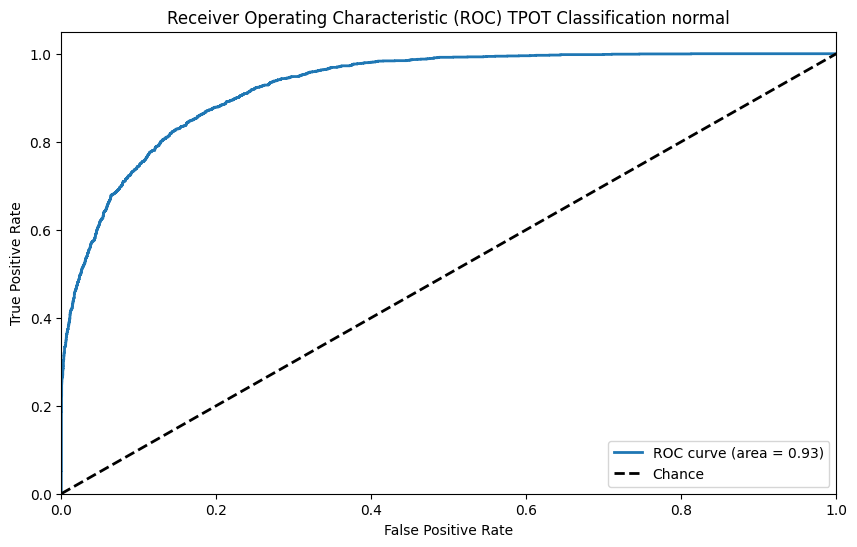

In [28]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

y_pred = tpot.predict(X_test)

# Predicting the probabilities for the positive class
y_pred_proba = tpot.predict_proba(X_test)[:, 1]

# Calculating ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve using Matplotlib with Seaborn styling
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', lw=2)
plt.plot([0, 1], [0, 1], 'k--', label='Chance', lw=2)  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) TPOT Classification normal')
plt.legend(loc="lower right")

# Save the plot as a PNG file
plt.savefig('tpot_roc_curve_normal.png', dpi=300)
plt.show()

In [29]:
tpot.export('tpot_classification_normal')